# Analyze conformational entropy, as computed by CREST / GFN2 across a large molecular test set

In [1]:
from __future__ import print_function

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")

from scipy import constants

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

We'll read in the combined CSV, including subset name, filename, SMILES, computational entropy, and a variety of descriptors generated by RDKit

In [2]:
df = pd.read_csv("combined-entropy.csv")
# drop nan
df.dropna(inplace=True)
print(len(df.index))
# 93543 molecules left
#  (technically we should check to make sure all the SMILES are unique!)

94062
93543


In [3]:
# what do we have
print(df.columns)
df.describe()

Index(['Category', 'File', 'SMILES', 'Entropy', 'NumRotors', 'NumMethyl',
       'NumAmine', 'NumHydroxyl', 'HDonors', 'HAcceptors', 'RingCount',
       'NumAromaticRings', 'ExactMolWt', 'MaxAbsPartialChg',
       'MinAbsPartialChg', 'MaxPartialChg', 'MinPartialChg', 'TPSA',
       'LabuteASA', 'MolMR', 'MolLogP', 'EState_VSA1', 'EState_VSA2',
       'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'HallKierAlpha', 'BertzCT',
       'BalabanJ', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'FractionCSP3',
       'Asphericity', 'Eccentricity', 'InertialShapeFactor',
       'RadiusOfGyration', 'SpherocityIndex', 'ConfUnder1', 'ConfUnder2',
       'ConfUnder3', 'ConfUnder4', 'ConfUnder5', 'ConfUnder6'],
      dtype='object')


,Entropy,NumRotors,NumMethyl,NumAmine,NumHydroxyl,HDonors,HAcceptors,RingCount,NumAromaticRings,ExactMolWt,...,Eccentricity,InertialShapeFactor,RadiusOfGyration,SpherocityIndex,ConfUnder1,ConfUnder2,ConfUnder3,ConfUnder4,ConfUnder5,ConfUnder6
count,93543.000000,93543.000000,93543.00000,93543.000000,93543.000000,93543.000000,93543.000000,93543.000000,93543.000000,93543.000000,...,93543.000000,93543.000000,93543.000000,93543.000000,93543.000000,93543.000000,93543.000000,93543.000000,93543.000000,93543.000000
mean,34.453231,4.574859,2.32322,0.137178,0.842457,1.531574,5.129416,3.950921,2.308682,408.313212,...,0.947388,0.000902,4.294947,0.172407,7.395775,19.505575,36.974995,58.744599,83.798104,111.117967
std,11.851837,2.636964,2.04187,0.437735,1.725989,1.756476,2.880881,1.740430,1.580702,113.309995,...,0.058016,0.001575,0.946011,0.132832,11.475761,31.780216,60.248477,95.155245,135.344965,177.385966
min,0.004000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56.062600,...,0.169475,0.000013,1.016678,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,27.086000,3.000000,1.00000,0.000000,0.000000,0.000000,3.000000,3.000000,1.000000,333.157623,...,0.924252,0.000330,3.642106,0.081008,2.000000,4.000000,6.000000,8.000000,10.000000,11.000000
50%,36.077000,4.000000,2.00000,0.000000,0.000000,1.000000,5.000000,4.000000,2.000000,420.178418,...,0.967986,0.000567,4.279916,0.140211,4.000000,10.000000,17.000000,26.000000,36.000000,46.000000
75%,42.992500,6.000000,3.00000,0.000000,1.000000,2.000000,7.000000,5.000000,3.000000,474.095082,...,0.988329,0.000973,4.919895,0.229202,9.000000,23.000000,44.000000,71.000000,102.000000,138.000000
max,68.287000,20.000000,26.00000,9.000000,14.000000,15.000000,30.000000,64.000000,58.000000,2039.240573,...,0.999999,0.162280,12.050900,0.989008,495.000000,981.000000,1445.000000,1957.000000,3171.000000,4437.000000


The goal is to understand how the computed conformational entropies change with molecular structure (e.g., number of rotatable bonds).

First off, let's try the formula from "Large-scale calculations of gas phase thermochemistry: Enthalpy of formation, standard entropy, and heat capacity"
*J. Chem. Phys.* 145 art. 114305 (2016); https://doi.org/10.1063/1.4962627

$$ S_{conf} = R \times (\textrm{Number of Rotors})$$

In [4]:
import sklearn
from sklearn.metrics import mean_absolute_error

pred = constants.R * df['NumRotors']
print(mean_absolute_error(df['Entropy'], pred))

15.8121252524764


Not very good - 15.8 J/mol*K

What does the data look like - comparing entropy against the # of rotatable bonds?

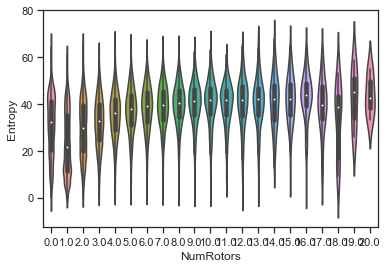

In [5]:
sns.violinplot(x="NumRotors", y="Entropy", data=df)

Clearly entropy isn't very linear with the number of rotatable bonds - but perhaps we can get better error with a full linear model

In [6]:
lm = ols('Entropy~NumRotors', data=df).fit()
print(lm.summary())
print('mean absolute error:', mean_absolute_error(df['Entropy'], lm.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:                Entropy   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                 1.601e+04
Date:                Wed, 02 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:24:25   Log-Likelihood:            -3.5662e+05
No. Observations:               93543   AIC:                         7.133e+05
Df Residuals:                   93541   BIC:                         7.133e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.5926      0.072    370.869      0.0

Nice, we've dropped the MAE from 15.8 J/mol•K to 8.8 J/mol•K - although clearly this isn't a great model either

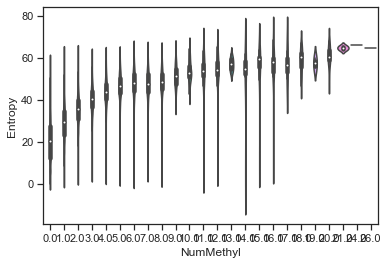

In [7]:
sns.violinplot(x="NumMethyl", y="Entropy", data=df)

The # of methyl groups seems to have a much better prediction of conformational entropy

In [8]:
lm = ols('Entropy~NumRotors+NumMethyl', df).fit()
print(lm.summary())
print('mean absolute error:', mean_absolute_error(df['Entropy'], lm.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:                Entropy   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                 6.690e+04
Date:                Wed, 02 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:24:26   Log-Likelihood:            -3.2248e+05
No. Observations:               93543   AIC:                         6.450e+05
Df Residuals:                   93540   BIC:                         6.450e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.5442      0.055    358.530      0.0

In [9]:
lm = ols('Entropy~np.log(NumRotors+1)+np.log(NumMethyl+1)', df).fit()
print(lm.summary())
print('mean absolute error:', mean_absolute_error(df['Entropy'], lm.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:                Entropy   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                 9.556e+04
Date:                Wed, 02 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:24:26   Log-Likelihood:            -3.1196e+05
No. Observations:               93543   AIC:                         6.239e+05
Df Residuals:                   93540   BIC:                         6.240e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                10.95

Okay, so this new model drops the MAE down to 5.3 J/mol•K which is almost a third of the initial model
What other factors are relevant?

In [11]:
formula = 'Entropy~' + '+'.join(df.columns[4:])
print(formula)

Entropy~NumRotors+NumMethyl+NumAmine+NumHydroxyl+HDonors+HAcceptors+RingCount+NumAromaticRings+ExactMolWt+MaxAbsPartialChg+MinAbsPartialChg+MaxPartialChg+MinPartialChg+TPSA+LabuteASA+MolMR+MolLogP+EState_VSA1+EState_VSA2+EState_VSA3+EState_VSA4+EState_VSA5+HallKierAlpha+BertzCT+BalabanJ+Ipc+Kappa1+Kappa2+Kappa3+FractionCSP3+Asphericity+Eccentricity+InertialShapeFactor+RadiusOfGyration+SpherocityIndex+ConfUnder1+ConfUnder2+ConfUnder3+ConfUnder4+ConfUnder5+ConfUnder6
